In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy import stats
from sklearn.ensemble import BaggingClassifier

import category_encoders as ce

from imblearn.pipeline import Pipeline
from scipy.stats import mannwhitneyu
from sklearn.ensemble import AdaBoostClassifier


import pingouin as pg
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, precision_score, plot_confusion_matrix, plot_roc_curve, roc_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Application Record
- ID: Client number
- CODE_GENDER: Gender (M / Y)
- FLAG_OWN_CAR: Is there a car?
- FLAG_OWN_REALTY: Is there a property?
- CNT_CHILDREN: Number of children
- AMT_INCOME_TOTAL: Annual income
- NAME_INCOME_TYPE: Income category
- NAME_EDUCATION_TYPE: Education level
- NAME_FAMILY_STATUS: Marital status
- NAME_HOUSING_TYPE: Way of living
- DAYS_BIRTH: Birthday (Count backwards from current day (0), -1 means yesterday)
- DAYS_EMPLOYED: Start date of employment (Count backwards from current day(0). If positive, it means the person currently unemployed.
- FLAG_MOBIL: Is there a mobile phone?
- FLAG_WORK_PHONE: Is there a work phone?
- FLAG_PHONE: Is there a phone?
- FLAG_EMAIL: Is there an email?
- OCCUPATION_TYPE: Occupation
- CNT_FAM_MEMBERS: Family size

#### Credit Record
- ID: Client number	
- MONTHS_BALANCE: Record month (The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on)
- STATUS: Status (
1. 0: 1-29 days past due 
2. 1: 30-59 days past due 
3. 2: 60-89 days overdue 
4. 3: 90-119 days overdue 
5. 4: 120-149 days overdue 
6. 5: Overdue or bad debts, write-offs for more than 150 days
7. C: paid off that month 
8. X: No loan for the month
)

In [2]:
crec = pd.read_csv('../credit_record.csv')
crec.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [3]:
appdf = pd.read_csv('../application_record.csv')
appdf.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [4]:
print(f'Credit Record, {crec.shape[0]} Data and {crec.shape[1]} Columns')
print(f'Application Record, {appdf.shape[0]} Data and {appdf.shape[1]} Columns')

Credit Record, 1048575 Data and 3 Columns
Application Record, 438557 Data and 18 Columns


`Credit Record` lebih banyak memiliki data karena `Credit Record` merupakan catatan dari setiap customer ID yang di update berdasarkan aktifitas Customer pada akun mereka, berbeda dengan `Application Record`

# PREPROCESSING

## Merge Dataset

In [5]:
app = pd.merge(appdf, crec, on = "ID", how = 'inner')
app.head()
# Menggunakan metode 'inner', karena saya ingin mengecek data terhadap ID yang sama antara kedua dataset

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C


In [6]:
## Mengecilkan (Lower) terhadap setiap kolom agar lebih mempermudah
app.columns = app.columns.str.lower()
app.columns

Index(['id', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'amt_income_total', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'days_birth',
       'days_employed', 'flag_mobil', 'flag_work_phone', 'flag_phone',
       'flag_email', 'occupation_type', 'cnt_fam_members', 'months_balance',
       'status'],
      dtype='object')

In [7]:
print(f'Total after Merge: {app.shape[0]} Data and {app.shape[1]} Columns')

Total after Merge: 777715 Data and 20 Columns


In [8]:
# app = app.sample(n = 100000, replace = False, random_state = 2020)

In [9]:
## Check duplicate ID
app['id'].value_counts().head(30000)

5096879    61
5066771    61
5105565    61
5069060    61
5091512    61
           ..
5142266     7
5116592     7
5125854     7
5036265     7
5033645     7
Name: id, Length: 30000, dtype: int64

Dapat dilihat diatas bahwa setelah melakukan proses penggabungan 2 dataset, kita memiliki kendala terhadap Customer ID yang berulang

In [10]:
app[app['id'] == 5116592].head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status
610916,5116592,M,Y,N,0,157500.0,Working,Higher education,Married,House / apartment,-15602,-611,1,0,0,0,NaN,2.0,-33,X
610917,5116592,M,Y,N,0,157500.0,Working,Higher education,Married,House / apartment,-15602,-611,1,0,0,0,NaN,2.0,-34,0
610918,5116592,M,Y,N,0,157500.0,Working,Higher education,Married,House / apartment,-15602,-611,1,0,0,0,NaN,2.0,-35,0
610919,5116592,M,Y,N,0,157500.0,Working,Higher education,Married,House / apartment,-15602,-611,1,0,0,0,NaN,2.0,-36,0
610920,5116592,M,Y,N,0,157500.0,Working,Higher education,Married,House / apartment,-15602,-611,1,0,0,0,NaN,2.0,-37,0


Dari cara pengecekan diatas saya dapat melihat aktifitas pinjaman berdasarkan `ID` seperti kapan customer tersebut melakukan kegiatan terakhir pada Akun Bank dan perubahan status Pinjaman pada setiap bulannya. Karena banyak dupkilasi data maka saya memutuskan untuk mendrop data duplikasi tersebut dan hanya menggunakan data `ID` pertama saja / kapan terakhir kalinya `ID` tersebut di update.

In [11]:
app = app.drop_duplicates(subset=['id'], keep = 'first')
app['id'].value_counts()

5048319    1
5139879    1
5089702    1
5125548    1
5118461    1
          ..
5112597    1
5053206    1
5051159    1
5126715    1
5048321    1
Name: id, Length: 36457, dtype: int64

In [12]:
app[app['id'] == 5116592]

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status
610916,5116592,M,Y,N,0,157500.0,Working,Higher education,Married,House / apartment,-15602,-611,1,0,0,0,NaN,2.0,-33,X


In [13]:
## Mengecek jumlah data, dan kolom
print(f'Sekarang kita memiliki data yang lebih sedikit yaitu {app.shape[0]} Data berdasarkan actual pengguna dari update terakhir')
# app.shape

Sekarang kita memiliki data yang lebih sedikit yaitu 36457 Data berdasarkan actual pengguna dari update terakhir


## Create `target` features based on `status`
1. 0: 1-29 days past due 
2. 1: 30-59 days past due 
3. 2: 60-89 days overdue 
4. 3: 90-119 days overdue 
5. 4: 120-149 days overdue 
6. 5: Overdue or bad debts, write-offs for more than 150 days
7. C: paid off that month 
8. X: No loan for the month

In [14]:
app.columns

Index(['id', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'amt_income_total', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'days_birth',
       'days_employed', 'flag_mobil', 'flag_work_phone', 'flag_phone',
       'flag_email', 'occupation_type', 'cnt_fam_members', 'months_balance',
       'status'],
      dtype='object')

In [15]:
orgX = app['status'].value_counts()[2]
orgC = app['status'].value_counts()[0]

In [16]:
pcntx = round(app.loc[app['status'] == 'X'].shape[0]/len(app)*100)
print(f'Jumlah Customer yang tidak memiliki pinjaman yaitu sebanyak {orgX} orang atau sekitar {pcntx}%')

Jumlah Customer yang tidak memiliki pinjaman yaitu sebanyak 8456 orang atau sekitar 27%


In [17]:
pcntc = round(app.loc[app['status'] == 'C'].shape[0]/len(app)*100)
print(f'Jumlah Customer yang telah membayar pinjaman yaitu sebanyak {orgC} orang atau sekitar {pcntc}%')

Jumlah Customer yang telah membayar pinjaman yaitu sebanyak 17950 orang atau sekitar 49%


Berdasarkan data diatas kita memiliki jumlah data yang cukup seimbang dimana (C & X) sekitar 76% dapat dikategorikan sebagai Customer yang tidak memiliki tanggungan hutang/tidak telat bayar, sedangkan sisanya (0 - 5) bisa kita kategorikan sebagai Customer yang masih memiliki tanggungan hutang.

In [18]:
app['status'].value_counts()

C    17950
X     9669
0     8456
1      276
5       76
2       19
3        6
4        5
Name: status, dtype: int64

In [19]:
app['target'] = np.where(app['status'].isin(['0', '1', '2', '3', '4', '5']), 1, 0)
# 0 - 5 akan menjadi 1, dan sisanya yaitu C dan X akan menjadi 0
# 1 berarti customer tersebut masih memiliki tanggungan/hutang
# 0 berarti customer tersebut tidak memiliki tanggungan/sudah bayar

In [20]:
app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 777701
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   36457 non-null  int64  
 1   code_gender          36457 non-null  object 
 2   flag_own_car         36457 non-null  object 
 3   flag_own_realty      36457 non-null  object 
 4   cnt_children         36457 non-null  int64  
 5   amt_income_total     36457 non-null  float64
 6   name_income_type     36457 non-null  object 
 7   name_education_type  36457 non-null  object 
 8   name_family_status   36457 non-null  object 
 9   name_housing_type    36457 non-null  object 
 10  days_birth           36457 non-null  int64  
 11  days_employed        36457 non-null  int64  
 12  flag_mobil           36457 non-null  int64  
 13  flag_work_phone      36457 non-null  int64  
 14  flag_phone           36457 non-null  int64  
 15  flag_email           36457 non-null

In [21]:
app[['id', 'status', 'target']].groupby('id').head()

,id,status,target
0,5008804,C,0
16,5008805,C,0
31,5008806,C,0
61,5008808,0,1
66,5008809,X,0
...,...,...,...
777622,5149828,5,1
777634,5149834,C,0
777658,5149838,C,0
777691,5150049,2,1


## Create `employed` features based on `days_employed`
Start date of employment (Count backwards from current day(0). If positive, it means the person currently unemployed.

In [22]:
app[['id', 'days_employed']]#.groupby('id').head()

,id,days_employed
0,5008804,-4542
16,5008805,-4542
31,5008806,-1134
61,5008808,-3051
66,5008809,-3051
...,...,...
777622,5149828,-2420
777634,5149834,-1325
777658,5149838,-1325
777691,5150049,-655


In [23]:
def working_status(x):
    if x >= 0:
        return 0
    elif x < 0:
        return 1
    else:
        return 'null'

app['employed'] = app['days_employed'].apply(lambda x: working_status(x))
# Membuat status bekerja, apabila bernilai negatif maka status bekerja menjadi 1 (sedang bekerja)
# Dan apabila bernilai positif maka status bekerja menjadi 0 (tidak bekerja)

In [24]:
app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 777701
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   36457 non-null  int64  
 1   code_gender          36457 non-null  object 
 2   flag_own_car         36457 non-null  object 
 3   flag_own_realty      36457 non-null  object 
 4   cnt_children         36457 non-null  int64  
 5   amt_income_total     36457 non-null  float64
 6   name_income_type     36457 non-null  object 
 7   name_education_type  36457 non-null  object 
 8   name_family_status   36457 non-null  object 
 9   name_housing_type    36457 non-null  object 
 10  days_birth           36457 non-null  int64  
 11  days_employed        36457 non-null  int64  
 12  flag_mobil           36457 non-null  int64  
 13  flag_work_phone      36457 non-null  int64  
 14  flag_phone           36457 non-null  int64  
 15  flag_email           36457 non-null

In [25]:
app[['id', 'days_employed','employed']].groupby('id').head() #.agg(min).reset_index()

,id,days_employed,employed
0,5008804,-4542,1
16,5008805,-4542,1
31,5008806,-1134,1
61,5008808,-3051,1
66,5008809,-3051,1
...,...,...,...
777622,5149828,-2420,1
777634,5149834,-1325,1
777658,5149838,-1325,1
777691,5150049,-655,1


In [26]:
app[app['employed'] == 0].head(3)

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,...,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,target,employed
137,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,1,0,0,0,NaN,1.0,-4,0,1,0
154,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,1,0,0,0,NaN,1.0,0,0,1,0
171,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,...,1,0,0,0,NaN,1.0,-1,0,1,0


## Create `age` features based on `days_birth`
Birthday (Count backwards from current day (0), -1 means yesterday)

In [27]:
app['days_birth'].isna().sum()

0

In [28]:
# Convert days_birth to age
app['days_birth'] = round(app['days_birth'] / -365).astype(int)
app['days_birth']

0         33
16        33
31        59
61        52
66        52
          ..
777622    48
777634    34
777658    34
777691    49
777701    25
Name: days_birth, Length: 36457, dtype: int64

In [29]:
app.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,...,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,target,employed
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,0,C,0,1
16,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,0,C,0,1
31,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,0,C,0,1
61,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,0,1,1
66,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,-22,X,0,1


In [30]:
# Rename days_birth to age
app = app.rename({'days_birth': 'age'}, axis=1)
app

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,...,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,months_balance,status,target,employed
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,0,C,0,1
16,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,...,1,1,0,0,NaN,2.0,0,C,0,1
31,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Security staff,2.0,0,C,0,1
61,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,0,0,1,1
66,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,...,1,0,1,1,Sales staff,1.0,-22,X,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
777622,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Managers,2.0,0,5,1,1
777634,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.0,0,C,0,1
777658,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,1,0,1,1,Medicine staff,2.0,0,C,0,1
777691,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,Sales staff,2.0,0,2,1,1


## Handling Missing Values

In [31]:
list_col = []
for col in app.columns:
    list_col.append([col, app[col].dtype, app[col].isna().sum(), round((app[col].isna().sum()/len(app[col]))*100, 2),
                    app[col].nunique(), list(app[col].sample(10).drop_duplicates().values)])
missdesc = pd.DataFrame(columns=['Feature dataType missValue missPercnt unique uniqueSample'.split()], data = list_col)
missdesc

,Feature,dataType,missValue,missPercnt,unique,uniqueSample
0,id,int64,0,0.00,36457,"[5114020, 5113983, 5037005, 5009342, 5135770, ..."
1,code_gender,object,0,0.00,2,"[F, M]"
2,flag_own_car,object,0,0.00,2,"[N, Y]"
3,flag_own_realty,object,0,0.00,2,"[Y, N]"
4,cnt_children,int64,0,0.00,9,"[0, 2, 1]"
5,amt_income_total,float64,0,0.00,265,"[202500.0, 247500.0, 67500.0, 144000.0, 135000..."
6,name_income_type,object,0,0.00,5,"[Commercial associate, Working]"
7,name_education_type,object,0,0.00,5,"[Secondary / secondary special, Higher education]"
8,name_family_status,object,0,0.00,5,"[Single / not married, Civil marriage, Married..."
9,name_housing_type,object,0,0.00,6,[House / apartment]


In [32]:
# (app.isna().sum()/len(app)*100).to_frame()

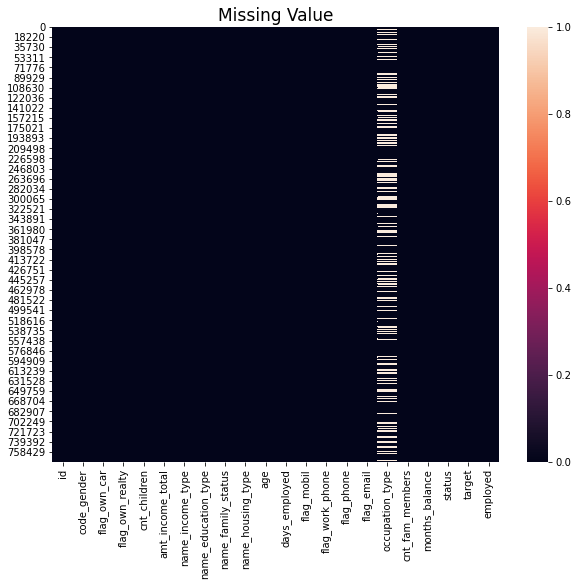

In [33]:
plt.figure(figsize = (10,8))
sns.heatmap(app.isna())
plt.title('Missing Value', size = 17)
plt.show()

Kolom `occupation_type` menjelaskan beberapa jenis pekerjaan, namun pada kolom tersebut juga terdapat `Nan` Values yang cukup banyak yaitu sebesar `31.1%` dari jumlah data. Maka saya memutuskan untuk drop kolom `occupation_type`. Tetapi sebelum di drop saya akan melihat insight dari kolom `occupation_type` terhadap kolom lainnya terlebih dahulu

In [34]:
app['occupation_type']

0                    NaN
16                   NaN
31        Security staff
61           Sales staff
66           Sales staff
               ...      
777622          Managers
777634    Medicine staff
777658    Medicine staff
777691       Sales staff
777701          Laborers
Name: occupation_type, Length: 36457, dtype: object

In [35]:
app.columns

Index(['id', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'amt_income_total', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'age', 'days_employed',
       'flag_mobil', 'flag_work_phone', 'flag_phone', 'flag_email',
       'occupation_type', 'cnt_fam_members', 'months_balance', 'status',
       'target', 'employed'],
      dtype='object')

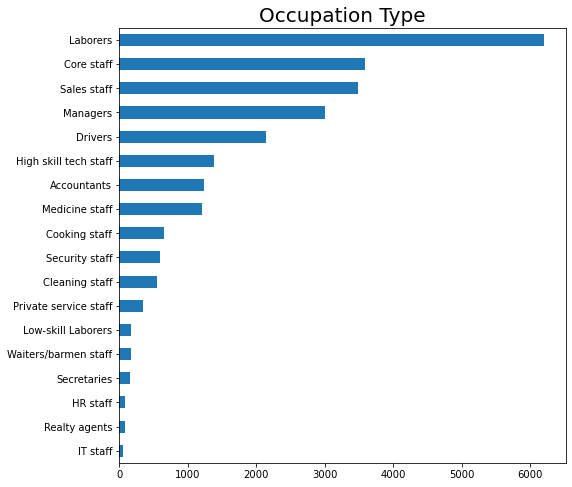

In [36]:
app['occupation_type'].value_counts(ascending = True).plot(kind = 'barh', figsize = (8,8))
plt.title('Occupation Type', size = 20)
plt.show()

In [37]:
app['occupation_type'].value_counts(normalize = 1, ascending = False).to_frame()

,occupation_type
Laborers,0.247115
Core staff,0.142874
Sales staff,0.138657
Managers,0.119838
Drivers,0.085064
High skill tech staff,0.055025
Accountants,0.049375
Medicine staff,0.048023
Cooking staff,0.026060
Security staff,0.023554


`IT Staff` memiliki jumlah rasio yang paling kecil, `Laborers` memiliki jumlah rasio yang paling besar

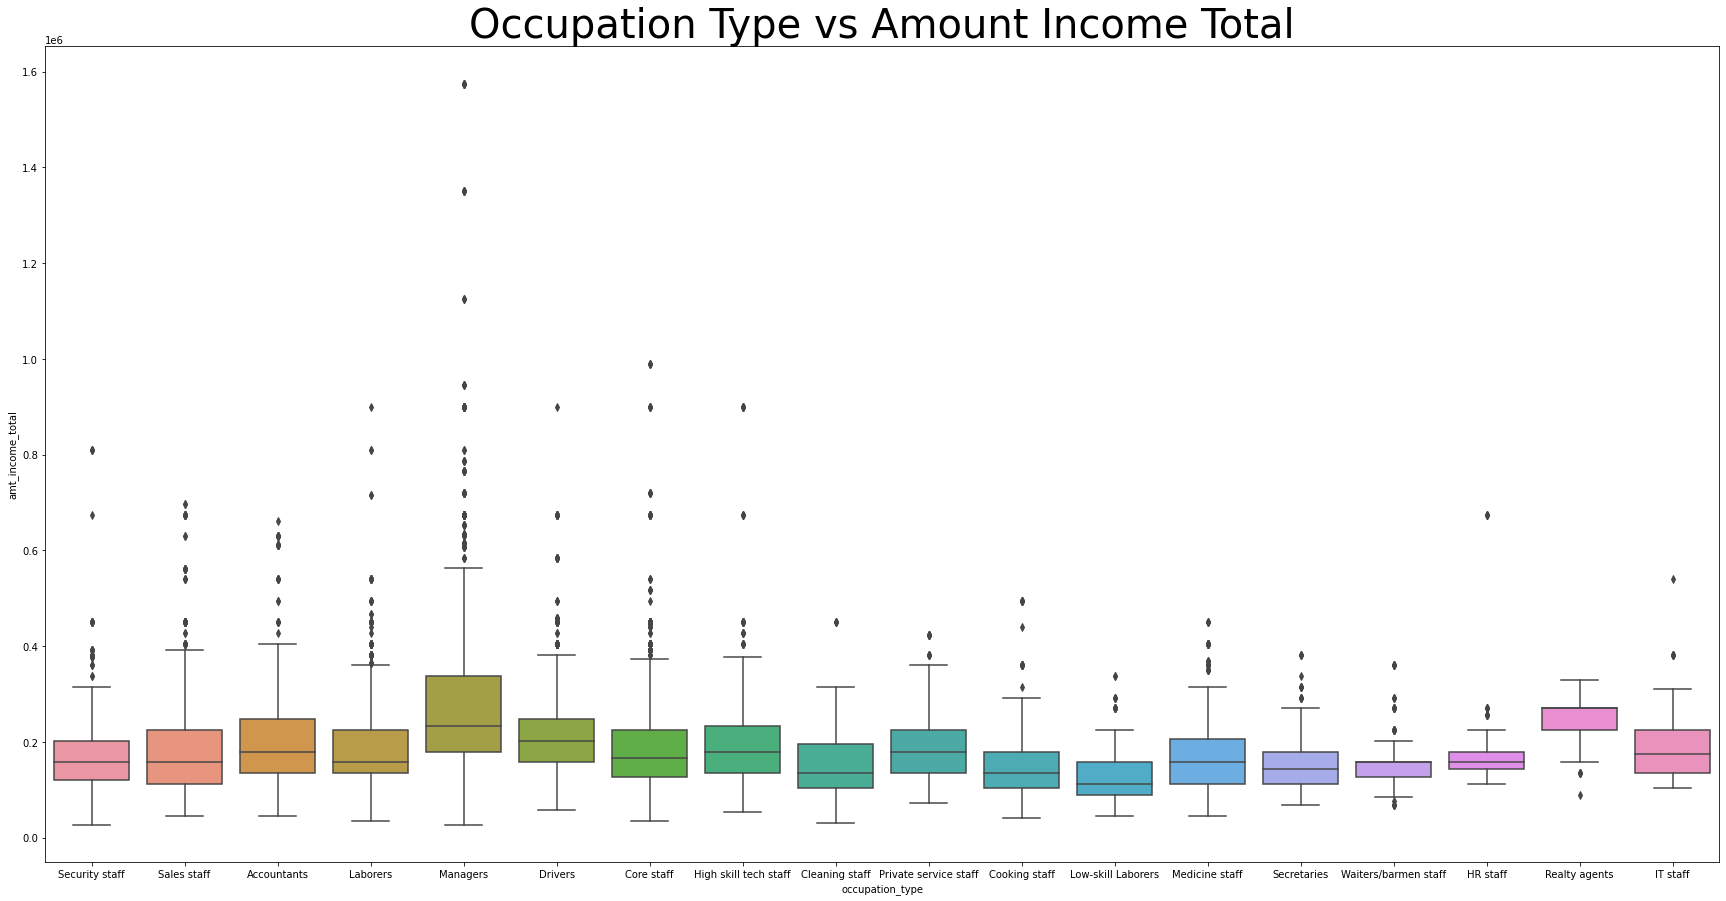

In [38]:
plt.figure(figsize=(30,15))
sns.boxplot(x = 'occupation_type', y = 'amt_income_total', data = app)
plt.title('Occupation Type vs Amount Income Total', size = 40)
plt.show()

Dari plot diatas dapat dilihat bahwa `occupation_type` berjenis `Managers` memiliki `amount_income_total` yang paling tinggi dibandingkan dengan `occupation_type` lainnya.

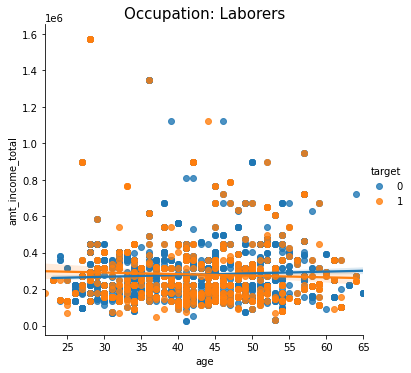

In [39]:
sns.lmplot(x = 'age', y = 'amt_income_total', hue = 'target', data = app[app['occupation_type']=='Managers'])
plt.title('Occupation: Laborers', size = 15)
plt.show()

In [40]:
# app[['occupation_type', 'amt_income_total']].value_counts().plot(kind = 'bar') #groupby('occupation_type')

In [41]:
# pd.crosstab(app['occupation_type'], app['target'], normalize = 0).value_counts(ascending = True) #.plot(kind = 'barh', stacked = False)

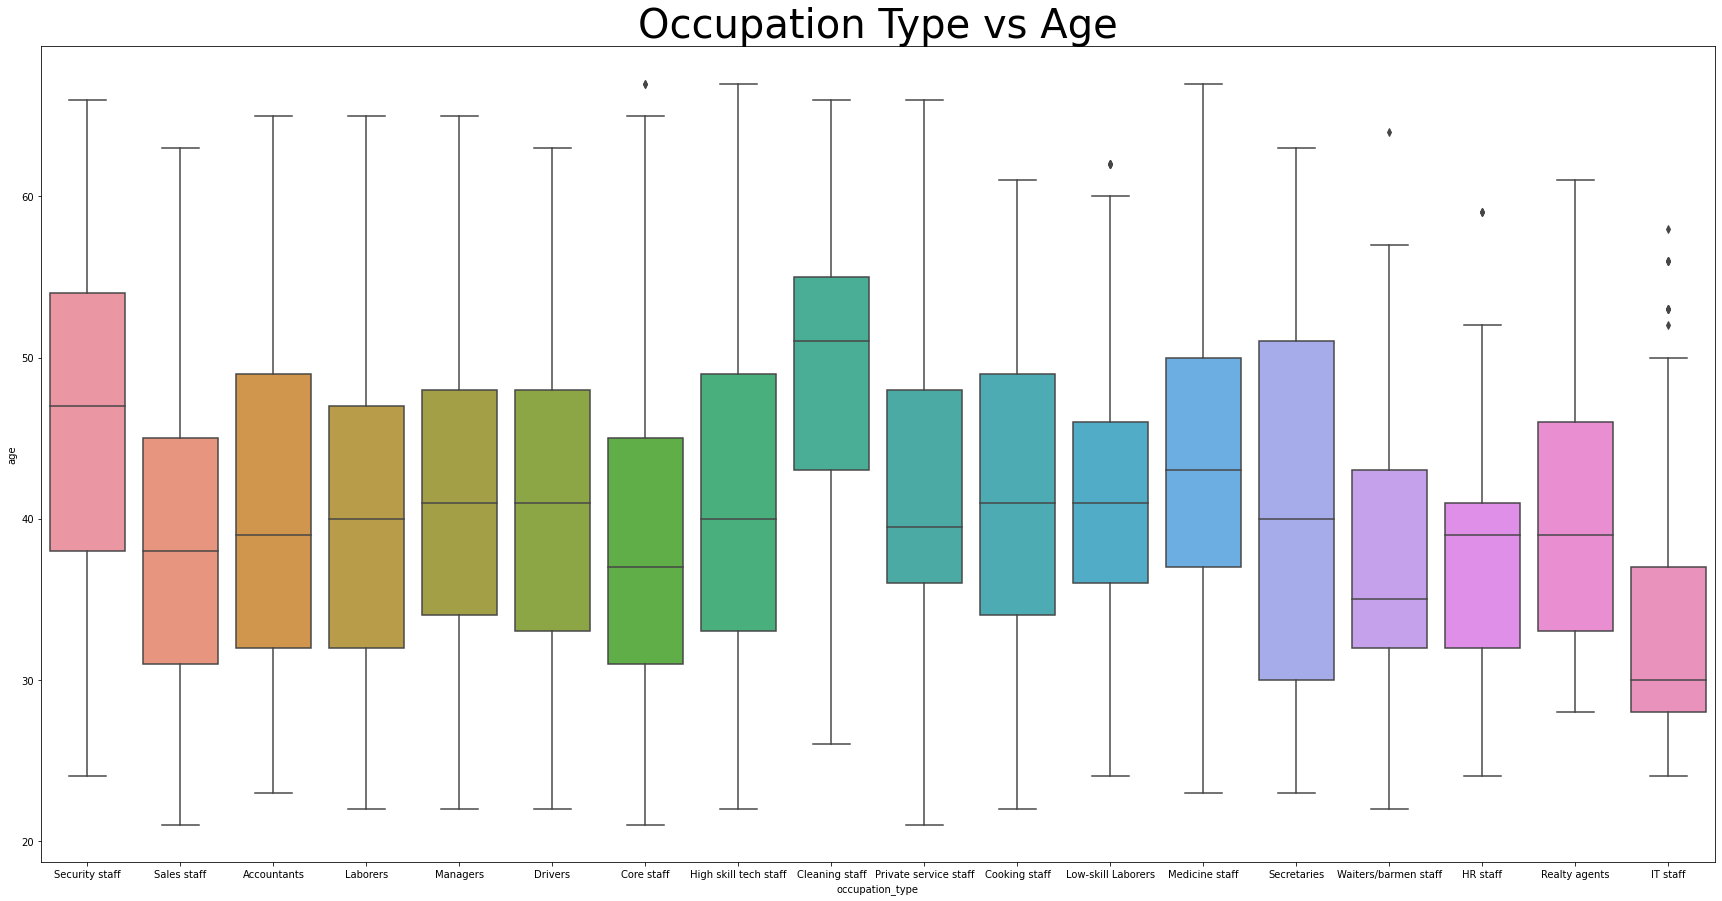

In [42]:
plt.figure(figsize=(30,15))
sns.boxplot(x = 'occupation_type', y = 'age', data = app)
plt.title('Occupation Type vs Age', size = 40)
plt.show()

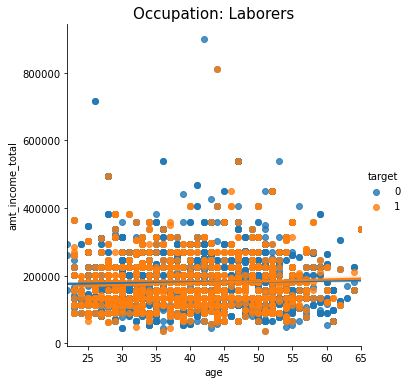

In [43]:
sns.lmplot(x = 'age', y = 'amt_income_total', hue = 'target', data = app[app['occupation_type']=='Laborers'])
plt.title('Occupation: Laborers', size = 15)
plt.show()

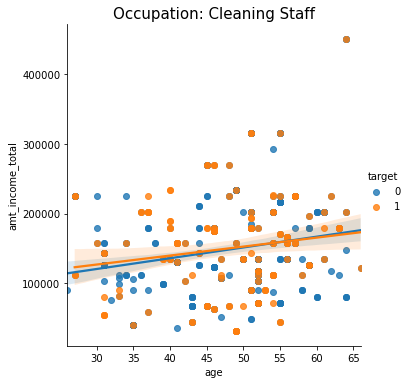

In [44]:
sns.lmplot(x = 'age', y = 'amt_income_total', hue = 'target', data = app[app['occupation_type']=='Cleaning staff'])
plt.title('Occupation: Cleaning Staff', size = 15)
plt.show()

In [45]:
# app.drop(app.query('occupation_type == "Laborers" and age > 45 and amt_income_total > 200000').index, inplace=True)
# app.drop(app.query('occupation_type == "Laborers" and amt_income_total > 400000').index, inplace=True)

In [46]:
# app.drop(app.query('occupation_type == "Security staff" and age > 50 and amt_income_total > 200000').index, inplace=True)
# #data.drop(data.query('OCCUPATION_TYPE=="Laborers" and AGE > 55').index, inplace=True)
# app.drop(app.query('occupation_type == "Security staff" and amt_income_total > 400000').index, inplace=True)


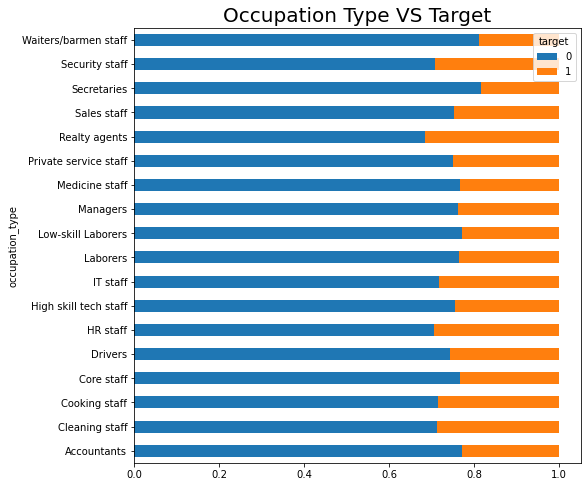

In [47]:
pd.crosstab(app['occupation_type'], app['target'], normalize = 0).plot(kind='barh', stacked=True, figsize = (8,8))
plt.title('Occupation Type VS Target', size = 20)
plt.show()

In [48]:
pd.crosstab(app['occupation_type'], app['target'], normalize = 0)

target,0,1
occupation_type,,
Accountants,0.771958,0.228042
Cleaning staff,0.713249,0.286751
Cooking staff,0.714504,0.285496
Core staff,0.765803,0.234197
Drivers,0.742750,0.257250
HR staff,0.705882,0.294118
High skill tech staff,0.755604,0.244396
IT staff,0.716667,0.283333
Laborers,0.763323,0.236677


Dari besaran rasio diatas dapat dilihat bahwa hampir semua `occupation_type` memiliki rasio `tidak memiliki tanggungan/hutang (0)` yang lebih besar dari pada yang `mimiliki tanggungan/hutang (1)`

# VISUALIZATION

## Gender & Target

<AxesSubplot:title={'center':'TARGET'}>

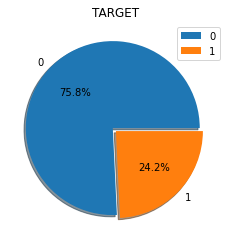

<AxesSubplot:title={'center':'GENDER'}>

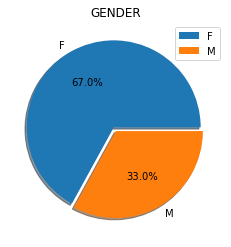

In [49]:
display(app['target'].value_counts(normalize=True).plot(kind='pie', title = 'TARGET', ylabel = '', explode = (0.05, 0), shadow = True, autopct = '%1.1f%%'))
plt.legend()
plt.show()
display(app['code_gender'].value_counts(normalize=True).plot(kind='pie', title = 'GENDER', ylabel = '', explode = (0.05, 0), shadow = True, autopct = '%1.1f%%'))
plt.legend()
plt.show()

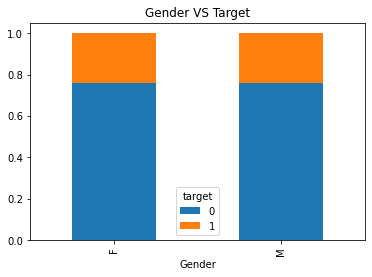

In [50]:
pd.crosstab(app.code_gender,app.target, normalize = 0).plot(kind = 'bar', xlabel = 'Gender', stacked = True)
plt.title('Gender VS Target')
plt.show()

In [51]:
pd.crosstab(app.code_gender,app.target, normalize = 0)

target,0,1
code_gender,,
F,0.757552,0.242448
M,0.757629,0.242371


`Male` dan `Female` memiliki rasio yang sama.

In [52]:
# app['code_gender'].value_counts(normalize=True).plot(kind='pie', title = 'GENDER', ylabel = '', explode = (0.05, 0), shadow = True, autopct = '%1.1f%%')
# plt.show()

## Family Status

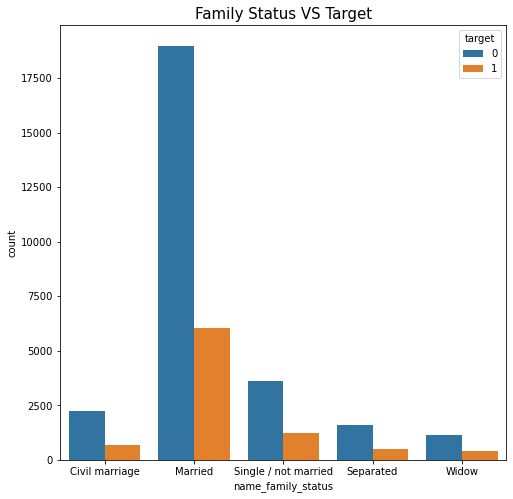

In [53]:
plt.figure(figsize = (8,8))
sns.countplot(x = 'name_family_status', hue = 'target', data = app)
plt.title('Family Status VS Target', size = 15)
plt.show()

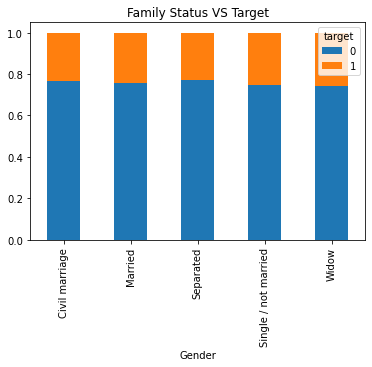

In [54]:
pd.crosstab(app.name_family_status,app.target, normalize = 0).plot(kind = 'bar', xlabel = 'Gender', stacked = True)
plt.title('Family Status VS Target')
plt.show()

In [55]:
pd.crosstab(app.name_family_status,app.target, normalize = 0)

target,0,1
name_family_status,,
Civil marriage,0.766723,0.233277
Married,0.758065,0.241935
Separated,0.770804,0.229196
Single / not married,0.748809,0.251191
Widow,0.741514,0.258486


## Education Type

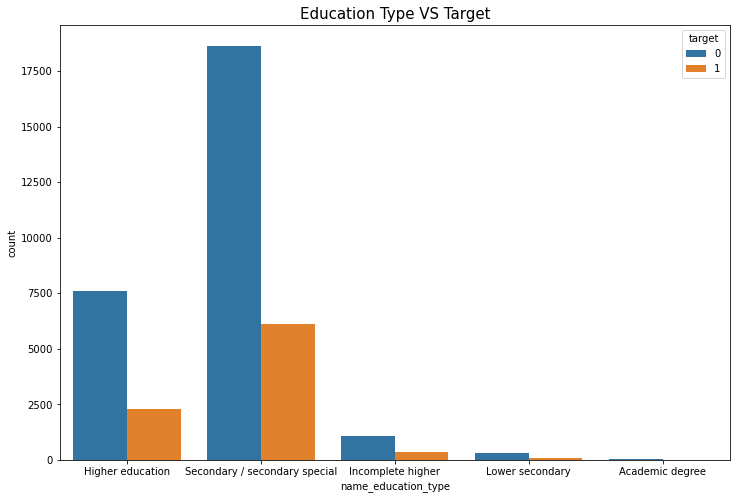

In [56]:
plt.figure(figsize = (12,8))
sns.countplot(x = 'name_education_type', hue = 'target', data = app)
plt.title('Education Type VS Target', size = 15)
plt.show()

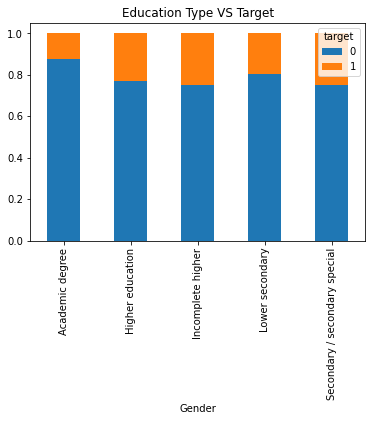

In [57]:
pd.crosstab(app.name_education_type,app.target, normalize = 0).plot(kind = 'bar', xlabel = 'Gender', stacked = True)
plt.title('Education Type VS Target')
plt.show()

In [58]:
pd.crosstab(app.name_education_type,app.target, normalize = 0)

target,0,1
name_education_type,,
Academic degree,0.875000,0.125000
Higher education,0.769769,0.230231
Incomplete higher,0.750355,0.249645
Lower secondary,0.802139,0.197861
Secondary / secondary special,0.752311,0.247689


## Income Type

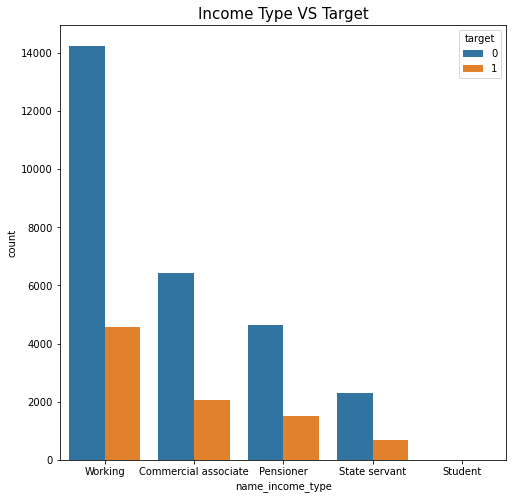

In [59]:
plt.figure(figsize = (8,8))
sns.countplot(x = 'name_income_type', hue = 'target', data = app)
plt.title('Income Type VS Target', size = 15)
plt.show()

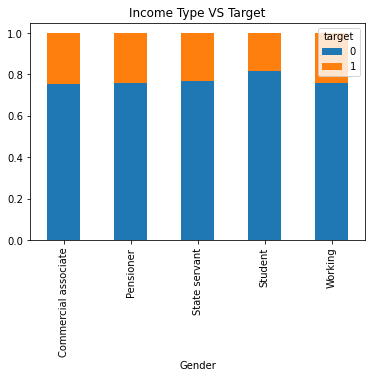

In [60]:
pd.crosstab(app.name_income_type,app.target, normalize = 0).plot(kind = 'bar', xlabel = 'Gender', stacked = True)
plt.title('Income Type VS Target')
plt.show()

In [61]:
pd.crosstab(app.name_income_type,app.target, normalize = 0)

target,0,1
name_income_type,,
Commercial associate,0.755948,0.244052
Pensioner,0.756502,0.243498
State servant,0.767504,0.232496
Student,0.818182,0.181818
Working,0.757054,0.242946


## Flag Own Car and Own Realty

<AxesSubplot:xlabel='flag_own_car'>

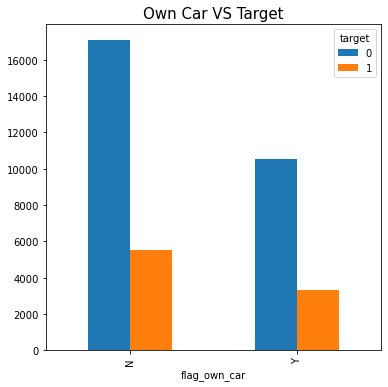

<AxesSubplot:xlabel='flag_own_realty'>

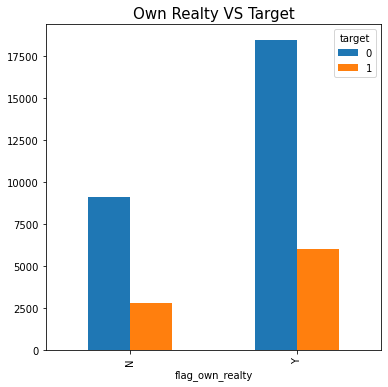

In [62]:
display(pd.crosstab(app['flag_own_car'], app['target']).plot(kind='bar', stacked=False, figsize = (6,6)))
plt.title('Own Car VS Target', size = 15)
plt.show()
display(pd.crosstab(app['flag_own_realty'], app['target']).plot(kind='bar', stacked=False, figsize = (6,6)))
plt.title('Own Realty VS Target', size = 15)
plt.show()

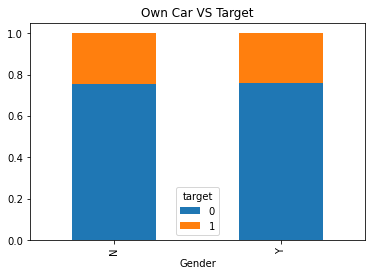

In [63]:
pd.crosstab(app.flag_own_car,app.target, normalize = 0).plot(kind = 'bar', xlabel = 'Gender', stacked = True)
plt.title('Own Car VS Target')
plt.show()

In [64]:
pd.crosstab(app.flag_own_car,app.target, normalize = 0)

target,0,1
flag_own_car,,
N,0.756301,0.243699
Y,0.759662,0.240338


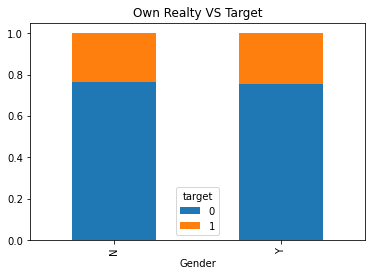

In [65]:
pd.crosstab(app.flag_own_realty,app.target, normalize = 0).plot(kind = 'bar', xlabel = 'Gender', stacked = True)
plt.title('Own Realty VS Target')
plt.show()

In [66]:
pd.crosstab(app.flag_own_realty,app.target, normalize = 0)

target,0,1
flag_own_realty,,
N,0.76479,0.23521
Y,0.75406,0.24594


## Housing Type

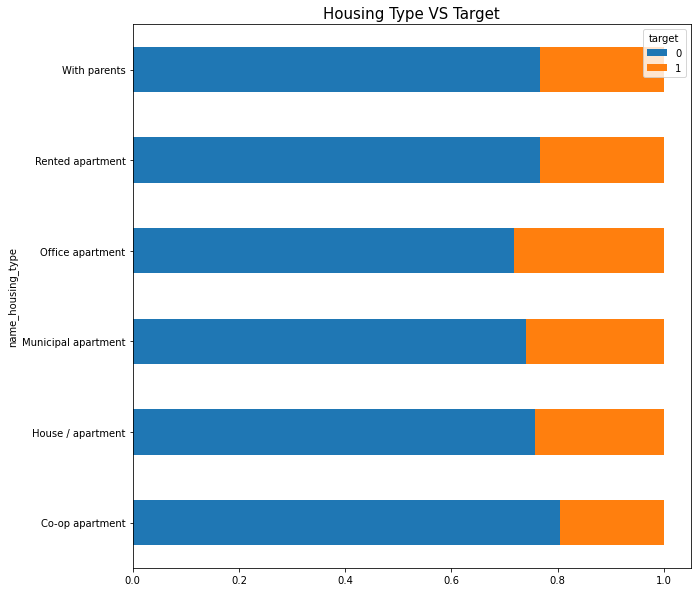

In [67]:
pd.crosstab(app['name_housing_type'], app['target'], normalize=0).plot(kind='barh', stacked=True, figsize = (10,10))
plt.title('Housing Type VS Target', size = 15)
plt.show()

In [68]:
pd.crosstab(app['name_housing_type'], app['target'], normalize=0)

target,0,1
name_housing_type,,
Co-op apartment,0.803571,0.196429
House / apartment,0.757650,0.242350
Municipal apartment,0.740248,0.259752
Office apartment,0.717557,0.282443
Rented apartment,0.766957,0.233043
With parents,0.765766,0.234234


## Number of Family

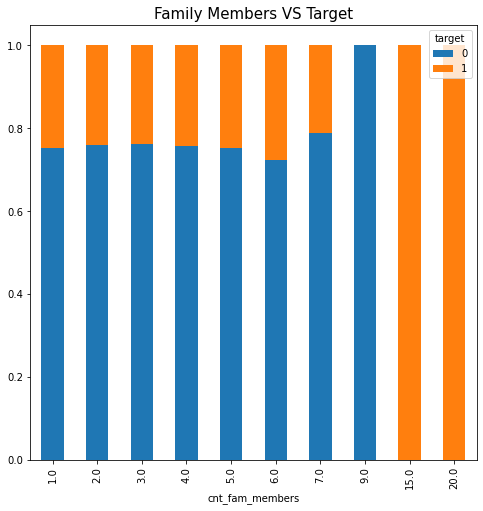

In [69]:
pd.crosstab(app['cnt_fam_members'], app['target'], normalize = 0).plot(kind='bar', stacked=True, figsize = (8,8))
plt.title('Family Members VS Target', size = 15)
plt.show()

In [70]:
pd.crosstab(app['cnt_fam_members'], app['target'], normalize = 0)

target,0,1
cnt_fam_members,,
1.0,0.752254,0.247746
2.0,0.758208,0.241792
3.0,0.762810,0.237190
4.0,0.756600,0.243400
5.0,0.753149,0.246851
6.0,0.724138,0.275862
7.0,0.789474,0.210526
9.0,1.000000,0.000000
15.0,0.000000,1.000000


Terdapat hal yang kurang masuk akal pada bagian `cnt_fam_members` atau berapa banyak jumlah anggota keluarga. Disaat jumlah anggota keluarga menunjukan lebih dari 7 anggota, rasio dari data tersebut tidak stabil, yaitu ketika jumlah anggota keluarga sebesar 9 anggota rasionya sebesar 100% yang dikategorikan `tidak memiliki tanggungan hutang (0)`, sedangkan keluarga yang memiliki jumlah anggota sebanyak 15 - 20 anggota memiliki rasio sebesar 100% yang dikategorikan `masih memiliki tanggungan/hutang (1)`.

In [71]:
def size(x):
    if x <= 4:
        return 0 # 0 adalah kategori 'small' dengan ukuran keluarga <= 4 anggota 
    elif x > 4 and x < 9:
        return 1 # 1 adalah kategori 'medium' dengan ukuran keluarga 5 - 8 anggota
    elif x >= 9:
        return 2 # 2 adalah kategori 'large' dengan ukuran keluarga > dari 9 anggota
    else:
        return 'null'

app['family_size'] = app['cnt_fam_members'].apply(lambda x: size(x))

In [72]:
app[['cnt_fam_members', 'family_size']].groupby('family_size').head()

,cnt_fam_members,family_size
0,2.0,0
16,2.0,0
31,2.0,0
61,1.0,0
66,1.0,0
486,5.0,1
503,5.0,1
41988,5.0,1
42029,5.0,1
42069,5.0,1


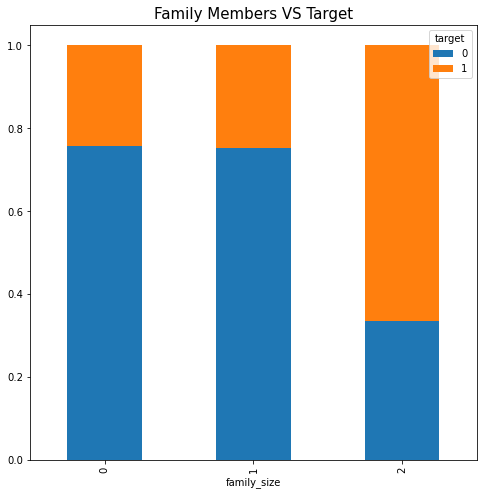

In [73]:
pd.crosstab(app['family_size'], app['target'], normalize = 0).plot(kind='bar', stacked=True, figsize = (8,8))
plt.title('Family Members VS Target', size = 15)
plt.show()

In [74]:
pd.crosstab(app['family_size'], app['target'], normalize = 0)

target,0,1
family_size,,
0,0.757734,0.242266
1,0.751055,0.248945
2,0.333333,0.666667


## Age Distribution

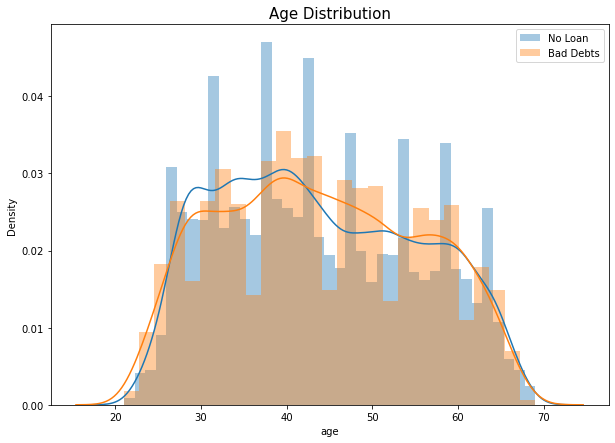

In [75]:
plt.figure(figsize=[10,7])
sns.distplot(app[app['target'] == 0]['age'], label='No Loan')
sns.distplot(app[app['target'] == 1]['age'], label='Bad Debts')
plt.title('Age Distribution', size = 15)
plt.legend()
plt.show()

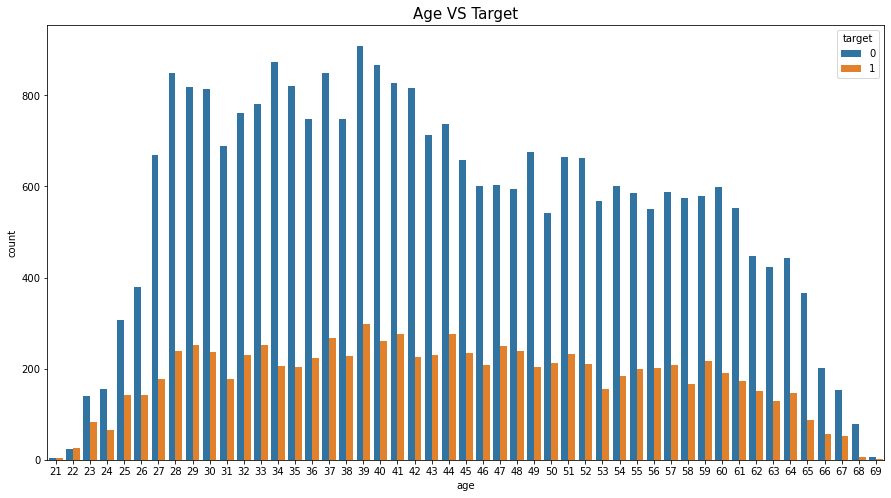

In [76]:
plt.figure(figsize = (15,8))
sns.countplot(x = 'age', hue = 'target', data = app)
plt.title('Age VS Target', size = 15)
plt.show()

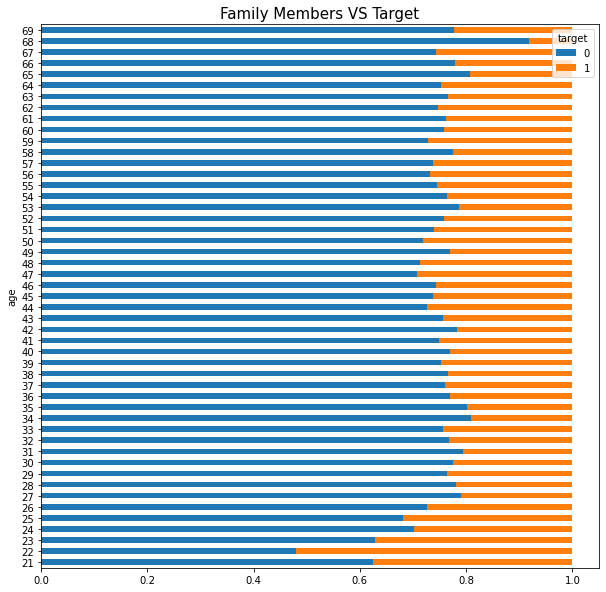

In [77]:
pd.crosstab(app['age'], app['target'], normalize = 0).plot(kind='barh', stacked=True, figsize = (10,10))
plt.title('Family Members VS Target', size = 15)
plt.show()

In [78]:
# Semakin tua mempengaruhi target (memiliki tanggungan / tidak)
pd.crosstab(app['age'], app['target'], normalize = 0)

target,0,1
age,,
21,0.625000,0.375000
22,0.480000,0.520000
23,0.627803,0.372197
24,0.701357,0.298643
25,0.681514,0.318486
26,0.726054,0.273946
27,0.789598,0.210402
28,0.780847,0.219153
29,0.764486,0.235514


Berdasarkan https://www.statcan.gc.ca/eng/concepts/definitions/age2, umur manusia dapat dikategorikan menjadi 3, yaitu:
1. Youth (15 - 24 tahun)
2. Adults (25 - 64 tahun)
3. Senior ( > 65 tahun)

In [79]:
def cat(x):
    if x <= 24:
        return 0 # 0 adalah kategori dari 'youth' yaitu umur 15 - 24 tahun 
    elif x > 24 and x < 65:
        return 1 # 1 adalah kategori dari 'adults' yaitu umur 25 - 64 tahun 
    elif x >= 65:
        return 2 # 2 adalah kategori dari 'senior' yaitu > 65 tahun 
    else:
        return 'null'

app['age_cat'] = app['age'].apply(lambda x: cat(x))

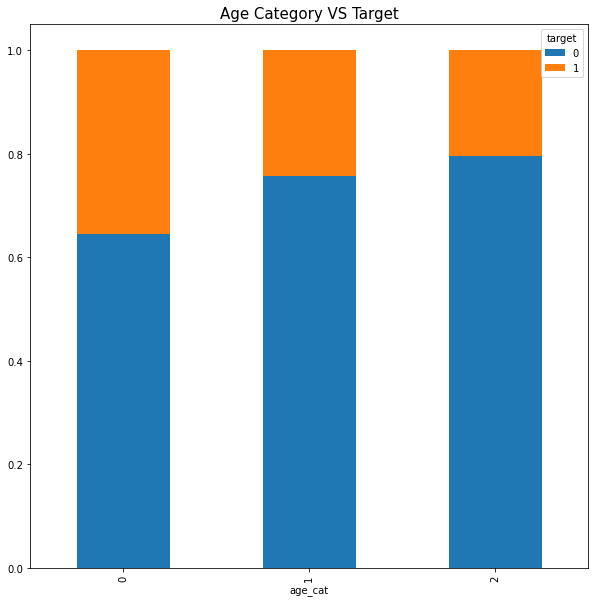

In [80]:
pd.crosstab(app['age_cat'], app['target'], normalize = 0).plot(kind='bar', stacked=True, figsize = (10,10))
plt.title('Age Category VS Target', size = 15)
plt.show()

In [81]:
pd.crosstab(app['age_cat'], app['target'], normalize = 0)

target,0,1
age_cat,,
0,0.645418,0.354582
1,0.758078,0.241922
2,0.795858,0.204142


rasio `memiliki tanggungan/hutang (1)` pada `youth` sedikit lebih besar. Hal tersebut mungkin karena kategori `youth` tersebut masih berstatus pelajar

In [82]:
app[['name_education_type', 'age_cat']].groupby('age_cat').head()

,name_education_type,age_cat
0,Higher education,1
16,Higher education,1
31,Secondary / secondary special,1
61,Secondary / secondary special,1
66,Secondary / secondary special,1
3685,Secondary / secondary special,0
3695,Secondary / secondary special,0
3705,Secondary / secondary special,0
4597,Higher education,0
10126,Secondary / secondary special,0


## Amount Income Total

Text(0.5, 1.0, 'Age Category vs Amount Income')

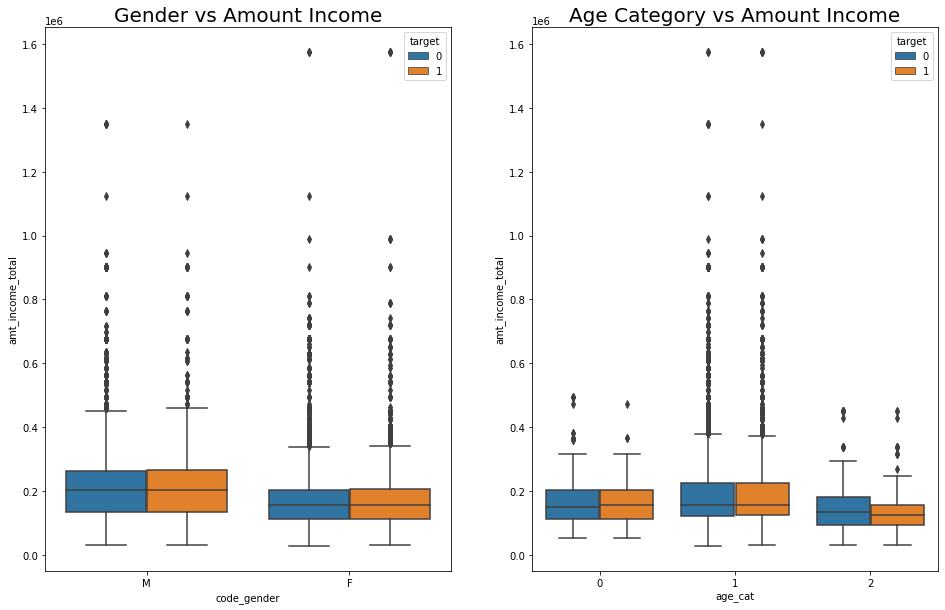

In [83]:
plt.figure(figsize=(16,10))
plt.subplot(121)
sns.boxplot(x = 'code_gender', y = 'amt_income_total', hue = 'target', data = app)
plt.title('Gender vs Amount Income', size = 20)
# plt.show()

# plt.figure(figsize=(16,10))
plt.subplot(122)
sns.boxplot(x = 'age_cat', y = 'amt_income_total', hue = 'target', data = app)
plt.title('Age Category vs Amount Income', size = 20)

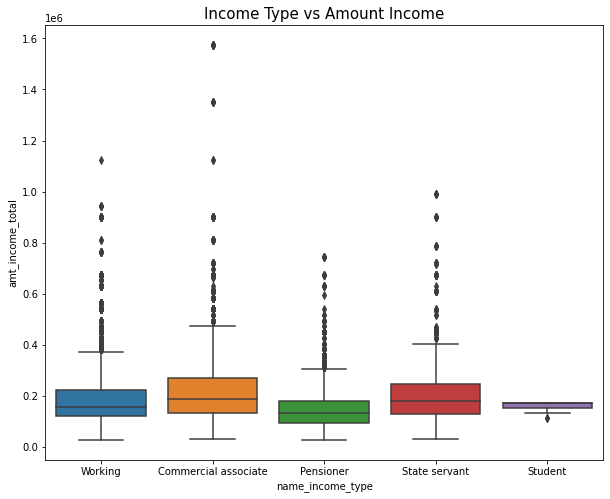

In [84]:
plt.figure(figsize=(10,8))
sns.boxplot(x = 'name_income_type', y = 'amt_income_total', data = app)
plt.title('Income Type vs Amount Income', size = 15)
plt.show()

## Count of Children

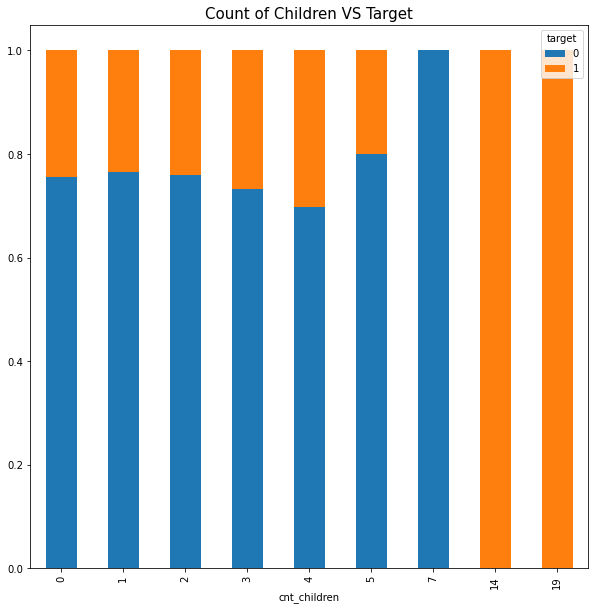

In [85]:
pd.crosstab(app['cnt_children'], app['target'], normalize = 0).plot(kind='bar', stacked=True, figsize = (10,10))
plt.title('Count of Children VS Target', size = 15)
plt.show()

In [86]:
pd.crosstab(app['cnt_children'], app['target'], normalize = 0)

target,0,1
cnt_children,,
0,0.755764,0.244236
1,0.764682,0.235318
2,0.760135,0.239865
3,0.732697,0.267303
4,0.698413,0.301587
5,0.800000,0.200000
7,1.000000,0.000000
14,0.000000,1.000000
19,0.000000,1.000000


In [87]:
def child(x):
    if x <= 2: 
        return 0 # 0 adalah kategori kepemilikan anak dari 0 - 2 anak
    elif x > 2 and x <= 5:
        return 1 # 1 adalah kategori kepemilikan anak dari 3 - 5 anak
    elif x >= 6: 
        return 2 # 2 adalah kategori kepemilikan anak lebih dari 5 anak
    else:
        return 'null'

app['cnt_child'] = app['cnt_children'].apply(lambda x: child(x))

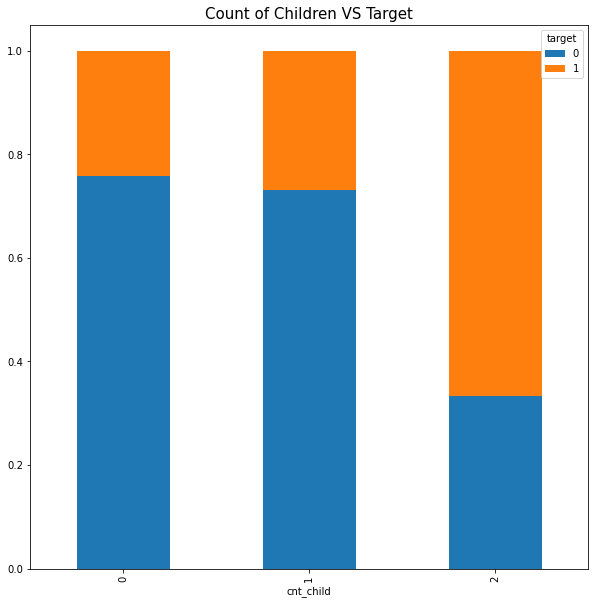

In [88]:
pd.crosstab(app['cnt_child'], app['target'], normalize = 0).plot(kind='bar', stacked=True, figsize = (10,10))
plt.title('Count of Children VS Target', size = 15)
plt.show()

In [89]:
pd.crosstab(app['cnt_child'], app['target'], normalize = 0)

target,0,1
cnt_child,,
0,0.758018,0.241982
1,0.731076,0.268924
2,0.333333,0.666667


# STRATEGY

## Drop some features

In [90]:
app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 777701
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   36457 non-null  int64  
 1   code_gender          36457 non-null  object 
 2   flag_own_car         36457 non-null  object 
 3   flag_own_realty      36457 non-null  object 
 4   cnt_children         36457 non-null  int64  
 5   amt_income_total     36457 non-null  float64
 6   name_income_type     36457 non-null  object 
 7   name_education_type  36457 non-null  object 
 8   name_family_status   36457 non-null  object 
 9   name_housing_type    36457 non-null  object 
 10  age                  36457 non-null  int64  
 11  days_employed        36457 non-null  int64  
 12  flag_mobil           36457 non-null  int64  
 13  flag_work_phone      36457 non-null  int64  
 14  flag_phone           36457 non-null  int64  
 15  flag_email           36457 non-null

Saya akan drop beberapa features, dan hanya memilih features yang sekiranya punya pengaruh terhadap `target`
1. `id`
2. `months_balance` karena saya telah mendrop duplicate `id` berdasarkan `months_balance` jadi perlu untuk di drop
3. `status` karena akan digantikan oleh `target`
4. `age` karena akan digantikan oleh `age_cat`
5. `days_employed` karena akan digantika oleh `employed`
6. `flag_mobil`
7. `flag_work_phone`
8. `flag_phone`
9. `flag_email`
10. `occupation_type` memiliki missing value
11. `cnt_fam_members` karena akan digantikan oleh `family_size`
12. `cnt_children` karena akan digantikan oleh `cnt_child`

In [91]:
app.columns

Index(['id', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'amt_income_total', 'name_income_type', 'name_education_type',
       'name_family_status', 'name_housing_type', 'age', 'days_employed',
       'flag_mobil', 'flag_work_phone', 'flag_phone', 'flag_email',
       'occupation_type', 'cnt_fam_members', 'months_balance', 'status',
       'target', 'employed', 'family_size', 'age_cat', 'cnt_child'],
      dtype='object')

In [92]:
app.drop(['id','months_balance', 'status', 'age', 'days_employed', 'flag_mobil', 'flag_work_phone', 'flag_phone', 
          'flag_email', 'occupation_type', 'cnt_fam_members'], axis=1, inplace=True)

In [93]:
app.drop(['cnt_children'], axis=1, inplace=True)

In [94]:
app.head()

,code_gender,flag_own_car,flag_own_realty,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,target,employed,family_size,age_cat,cnt_child
0,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,0,1,0,1,0
16,M,Y,Y,427500.0,Working,Higher education,Civil marriage,Rented apartment,0,1,0,1,0
31,M,Y,Y,112500.0,Working,Secondary / secondary special,Married,House / apartment,0,1,0,1,0
61,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,1,0,1,0
66,F,N,Y,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,0,1,0,1,0


In [95]:
app.columns

Index(['code_gender', 'flag_own_car', 'flag_own_realty', 'amt_income_total',
       'name_income_type', 'name_education_type', 'name_family_status',
       'name_housing_type', 'target', 'employed', 'family_size', 'age_cat',
       'cnt_child'],
      dtype='object')

## Strategy Encoder

1. _OneHot Encoder_ : `code_gender`, `flag_own_car`, `flag_own_realty`

2. _Binary Encoder_ : `name_income_type`, `name_family_status`, `name_housing_type`

3. _Ordinal Encoder_ : `name_education_type`

In [96]:
app.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 777701
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   code_gender          36457 non-null  object 
 1   flag_own_car         36457 non-null  object 
 2   flag_own_realty      36457 non-null  object 
 3   amt_income_total     36457 non-null  float64
 4   name_income_type     36457 non-null  object 
 5   name_education_type  36457 non-null  object 
 6   name_family_status   36457 non-null  object 
 7   name_housing_type    36457 non-null  object 
 8   target               36457 non-null  int64  
 9   employed             36457 non-null  int64  
 10  family_size          36457 non-null  int64  
 11  age_cat              36457 non-null  int64  
 12  cnt_child            36457 non-null  int64  
dtypes: float64(1), int64(5), object(7)
memory usage: 5.1+ MB


# MODELING

## Splitting

In [97]:
# fitur = ['code_gender', 'flag_own_realty', 'amt_income_total', 'name_education_type', '']
# target = ['target']

X = app.drop('target', axis = 1)
y = app['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y, random_state = 2020 )

In [98]:
X_train.head()

,code_gender,flag_own_car,flag_own_realty,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,employed,family_size,age_cat,cnt_child
734143,M,N,Y,157500.0,Working,Secondary / secondary special,Single / not married,House / apartment,1,0,1,0
369602,M,Y,Y,157500.0,Working,Higher education,Married,House / apartment,1,0,1,0
671407,M,N,Y,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,0
555795,M,Y,N,261000.0,State servant,Higher education,Married,Municipal apartment,1,0,1,0
397122,F,Y,Y,225000.0,Working,Higher education,Married,House / apartment,1,0,1,0


In [99]:
X_train.isna().any()

code_gender            False
flag_own_car           False
flag_own_realty        False
amt_income_total       False
name_income_type       False
name_education_type    False
name_family_status     False
name_housing_type      False
employed               False
family_size            False
age_cat                False
cnt_child              False
dtype: bool

In [100]:
# OneHotEncoder = code_gender, flag_own_car, flag_own_realty
# BinaryEncoder = name_income_type, name_family_status,name_housing_type
# Ordinal Encoder = name_education_type

In [101]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

## Pipeline

In [102]:
# Education Mapping
edu_mapping = [
    {
        'col': 'name_education_type',
        'mapping': {None:0, 'Lower secondary':1, 'Secondary / secondary special':2, 'Incomplete higher':3,
                    'Higher education':4, 'Academic degree':5}
    }
]

# Education Pipe
pipe_edu = Pipeline([
    ('ordinal', ce.OrdinalEncoder(cols=['name_education_type'], mapping = edu_mapping))
])


# Transformer
transformer = ColumnTransformer([
    ('ordinal_edu', pipe_edu, ['name_education_type']),
    ('onehot', OneHotEncoder(drop = 'first'), ['code_gender', 'flag_own_car', 'flag_own_realty']),
    ('binary', ce.BinaryEncoder(), ['name_income_type', 'name_family_status', 'name_housing_type'])
], remainder='passthrough')

In [103]:
# MODEL INIALIZING

# Logit
logit = LogisticRegression(class_weight='balanced')
smote = SMOTE()

# DTC with RFE
dtc = DecisionTreeClassifier()#criterion = 'gini', max_depth = 10,min_samples_split = 5, random_state = 2020)
rfe_dtc = RFE(estimator = dtc)

# RandomForest with RFE
randforest = RandomForestClassifier()#criterion = 'gini', max_depth = 10, min_samples_split = 5, n_estimators = 50)
rfe_randforest = RFE(estimator = randforest)

# GradientBoost
gbc = GradientBoostingClassifier()#learning_rate=0.5,max_depth=10, min_samples_split=2 ,n_estimators=50)

# KNN
knn = KNeighborsClassifier()#leaf_size = 10, n_neighbors = 7)

# Bagging
bagging = BaggingClassifier(base_estimator = logit, n_estimators=10, oob_score=True, n_jobs=-1) ##n_jobs = -1 sangat membantu ketika menginterpretasikan 

# Scaler
scaler = RobustScaler()


# Logit
logit_model = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTE()),
    ('clf', logit)
])

# DTC with RFE
dtc_model = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTE()),
    ('rfe', rfe_dtc),
    ('clf', dtc)
])

# RandomForest with RFE
randforest_model = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTE()),
    ('rfe', rfe_randforest),
    ('clf', randforest)
])

# Gradient Boost
gbc_model = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTE()),
    ('clf', gbc)
])

# KNN
knn_model = Pipeline([
    ('transformer', transformer),
    ('scale', scaler),
    ('sampling', SMOTE()),
    ('clf', knn)
])

## Bagging Classifier
bag_model = Pipeline([
    ('transformer', transformer),
    ('clf', bagging)
])

tree = DecisionTreeClassifier(max_depth = 3)
abc = AdaBoostClassifier(tree, n_estimators = 200, learning_rate = 0.1, random_state = 10)

abc_model = Pipeline([
    ('transformer', transformer),
    ('clf', abc)
])


## Accuracy

In [104]:
skfold = StratifiedKFold(n_splits = 5)

logit_cv = cross_val_score(logit_model, X_train, y_train, cv = skfold)
knn_cv = cross_val_score(knn_model, X_train, y_train, cv = skfold)
tree_cv = cross_val_score(dtc_model, X_train, y_train, cv = skfold)

In [105]:
print('CV Logreg: ', logit_cv)
print('CV KNN: ', knn_cv)
print('CV DTC: ', tree_cv)

CV Logreg:  [0.24241385 0.24241385 0.24241385 0.24241385 0.24241385]
CV KNN:  [0.61014915 0.5969484  0.62935025 0.60980627 0.62437854]
CV DTC:  [0.64409395 0.63997943 0.64512258 0.64717984 0.65815189]


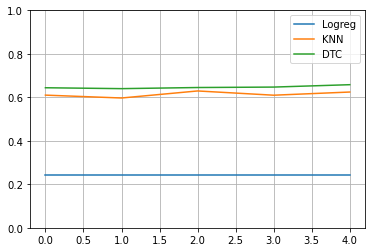

In [106]:
plt.plot(range(len(logit_cv)), logit_cv, label = 'Logreg')
plt.plot(range(len(knn_cv)), knn_cv, label = 'KNN')
plt.plot(range(len(tree_cv)), tree_cv, label = 'DTC')
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

In [107]:
print('CV Logreg: ', logit_cv.mean())
print('CV KNN: ', knn_cv.mean())
print('CV DTC: ', tree_cv.mean())

CV Logreg:  0.24241385222012685
CV KNN:  0.6141265215155152
CV DTC:  0.6469055374592834


In [108]:
print('CV Logreg: ', logit_cv.std())
print('CV KNN: ', knn_cv.std())
print('CV DTC: ', tree_cv.std())

CV Logreg:  2.7755575615628914e-17
CV KNN:  0.011545021710784049
CV DTC:  0.006092795139719838


#### With Recall

In [109]:
skfold = StratifiedKFold(n_splits = 5)

logit_cv_rc = cross_val_score(logit_model, X_train, y_train, cv = skfold, scoring = 'recall')
knn_cv_rc = cross_val_score(knn_model, X_train, y_train, cv = skfold, scoring = 'recall')
tree_cv_rc = cross_val_score(dtc_model, X_train, y_train, cv = skfold, scoring = 'recall')

In [110]:
print('CV Logreg: ', logit_cv_rc)
print('CV KNN: ', knn_cv_rc)
print('CV DTC: ', tree_cv_rc)

CV Logreg:  [1. 1. 1. 1. 1.]
CV KNN:  [0.43422914 0.40240453 0.38755304 0.44695898 0.43140028]
CV DTC:  [0.38755304 0.35148515 0.35360679 0.39745403 0.36421499]


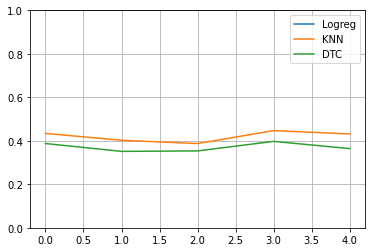

In [111]:
plt.plot(range(len(logit_cv_rc)), logit_cv_rc, label='Logreg')
plt.plot(range(len(knn_cv_rc)), knn_cv_rc, label='KNN')
plt.plot(range(len(tree_cv_rc)), tree_cv_rc, label='DTC')
plt.ylim(0,1)
plt.grid()
plt.legend()
plt.show()

In [112]:
print('CV Logreg:', logit_cv_rc.mean())
print('CV KNN:', knn_cv_rc.mean())
print('CV DTC:', tree_cv_rc.mean())

CV Logreg: 1.0
CV KNN: 0.4205091937765205
CV DTC: 0.37086280056577087


In [113]:
print('CV Logreg:', logit_cv_rc.std())
print('CV KNN:', knn_cv_rc.std())
print('CV DTC:', tree_cv_rc.std())

CV Logreg: 0.0
CV KNN: 0.022001504221047536
CV DTC: 0.01845597106917348


## Logistic Regression

In [114]:
logit_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_edu',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(cols=['name_education_type'],
                                                                                  mapping=[{'col': 'name_education_type',
                                                                                            'mapping': {None: 0,
                                                                                                        'Academic degree': 5,
                                                                                                        'Higher education': 4,
                                                                                                        'Incomplete higher': 3,
                                     

In [115]:
y_pred_logit = logit_model.predict(X_test)
print('Logistic Regression Model Score: \n')
print(classification_report(y_test, y_pred_logit))

Logistic Regression Model Score: 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5524
           1       0.24      1.00      0.39      1768

    accuracy                           0.24      7292
   macro avg       0.12      0.50      0.20      7292
weighted avg       0.06      0.24      0.09      7292



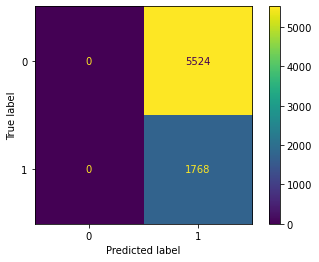

In [116]:
plot_confusion_matrix(logit_model, X_test, y_test)

In [117]:
logit_model.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinal_edu',
                                    Pipeline(steps=[('ordinal',
                                                     OrdinalEncoder(cols=['name_education_type'],
                                                                    mapping=[{'col': 'name_education_type',
                                                                              'mapping': {None: 0,
                                                                                          'Academic degree': 5,
                                                                                          'Higher education': 4,
                                                                                          'Incomplete higher': 3,
                                                                                          'Lower secondary': 1,
                                       

In [118]:
logit_model[0].transformers_[0][2]

['name_education_type']

In [119]:
# code_gender
logit_model[0].transformers_[1][2][0]

'code_gender'

In [120]:
# flag_own_car
logit_model[0].transformers_[1][2][1]

'flag_own_car'

In [121]:
# flag_own_realty
logit_model[0].transformers_[1][2][2]

'flag_own_realty'

In [122]:
# name_income_type
logit_model[0].transformers_[2][2][0]

'name_income_type'

In [123]:
# name_income_type
logit_model[0].transformers_[2][2][1]

'name_family_status'

In [124]:
# remainder
X_train.iloc[:,logit_model[0].transformers_[-1][-1]].columns

Index(['amt_income_total', 'employed', 'family_size', 'age_cat', 'cnt_child'], dtype='object')

## Logistic Regression Tuned

In [125]:
hyperparam_logit = {
    'clf__C': [0.5, 1.0, 1.5, 2],    
    'clf__max_iter': [50, 100, 200],
}

skf = StratifiedKFold(n_splits=5)

gridsearch = GridSearchCV(logit_model, hyperparam_logit, scoring = 'recall', n_jobs = -1, cv = skf)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal_edu',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder(cols=['name_education_type'],
                                                                                                         mapping=[{'col': 'name_education_type',
                                                                                                                   'mapping': {None: 0,
                                                                                                                               'Academic degree': 5,
                             

In [126]:
gridsearch.best_params_

{'clf__C': 0.5, 'clf__max_iter': 200}

In [127]:
logit_tuned = gridsearch.best_estimator_.fit(X_train, y_train)
y_pred_logit_tuned = logit_tuned.predict(X_test)

In [128]:
print('Logistic Regression Model Score \n')
print(classification_report(y_test, y_pred_logit))
print('======================================================')
print('Logistic Regression Tuned Model Score \n')
print(classification_report(y_test, y_pred_logit_tuned))

Logistic Regression Model Score 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5524
           1       0.24      1.00      0.39      1768

    accuracy                           0.24      7292
   macro avg       0.12      0.50      0.20      7292
weighted avg       0.06      0.24      0.09      7292

Logistic Regression Tuned Model Score 

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5524
           1       0.24      1.00      0.39      1768

    accuracy                           0.24      7292
   macro avg       0.12      0.50      0.20      7292
weighted avg       0.06      0.24      0.09      7292



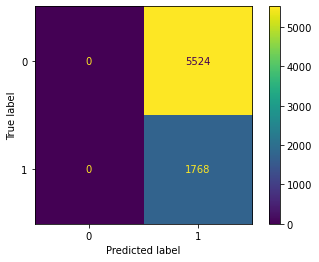

In [129]:
plot_confusion_matrix(logit_tuned, X_test, y_test)

## Decision Tree Classifier

In [130]:
dtc_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_edu',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(cols=['name_education_type'],
                                                                                  mapping=[{'col': 'name_education_type',
                                                                                            'mapping': {None: 0,
                                                                                                        'Academic degree': 5,
                                                                                                        'Higher education': 4,
                                                                                                        'Incomplete higher': 3,
                                     

In [131]:
y_pred_dtc = dtc_model.predict(X_test)
print('DTC Model Score: \n')
print(classification_report(y_test, y_pred_dtc))

DTC Model Score: 

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      5524
           1       0.33      0.44      0.38      1768

    accuracy                           0.65      7292
   macro avg       0.57      0.58      0.57      7292
weighted avg       0.69      0.65      0.66      7292



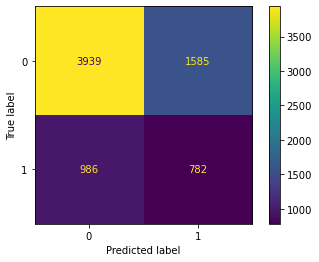

In [132]:
plot_confusion_matrix(dtc_model, X_test, y_test)

## DecisionTreeClassifier Tuned

In [133]:
hyperparam_dtc = {
    'clf__max_depth': [10,15,20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__criterion': ['entropy', 'gini'],
    'rfe__n_features_to_select': [None,5,6,7,8]
}

skf = StratifiedKFold(n_splits = 5)

gridsearch = GridSearchCV(dtc_model, hyperparam_dtc, scoring = 'recall', n_jobs = -1, cv = skf)
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal_edu',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder(cols=['name_education_type'],
                                                                                                         mapping=[{'col': 'name_education_type',
                                                                                                                   'mapping': {None: 0,
                                                                                                                               'Academic degree': 5,
                             

In [134]:
gridsearch.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 20,
 'clf__min_samples_split': 2,
 'rfe__n_features_to_select': None}

In [135]:
gridsearch.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_edu',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(cols=['name_education_type'],
                                                                                  mapping=[{'col': 'name_education_type',
                                                                                            'mapping': {None: 0,
                                                                                                        'Academic degree': 5,
                                                                                                        'Higher education': 4,
                                                                                                        'Incomplete higher': 3,
                                     

In [136]:
dtc_tuned = gridsearch.best_estimator_.fit(X_train, y_train)
y_pred_dtc_tuned = dtc_tuned.predict(X_test)

In [137]:
y_pred_dtc = dtc_model.predict(X_test)
print('DTC Model Score: \n')
print(classification_report(y_test, y_pred_dtc))
print('=====================================================')
print('DTC Tuned Model Score: \n')
print(classification_report(y_test, y_pred_dtc_tuned))

DTC Model Score: 

              precision    recall  f1-score   support

           0       0.80      0.71      0.75      5524
           1       0.33      0.44      0.38      1768

    accuracy                           0.65      7292
   macro avg       0.57      0.58      0.57      7292
weighted avg       0.69      0.65      0.66      7292

DTC Tuned Model Score: 

              precision    recall  f1-score   support

           0       0.79      0.71      0.75      5524
           1       0.32      0.43      0.36      1768

    accuracy                           0.64      7292
   macro avg       0.56      0.57      0.56      7292
weighted avg       0.68      0.64      0.66      7292



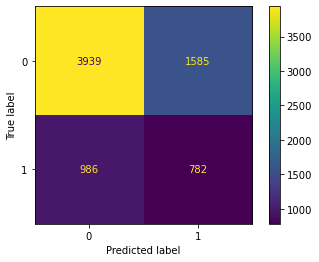

In [138]:
plot_confusion_matrix(dtc_model, X_test, y_test)

## KNN

In [139]:
knn_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_edu',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(cols=['name_education_type'],
                                                                                  mapping=[{'col': 'name_education_type',
                                                                                            'mapping': {None: 0,
                                                                                                        'Academic degree': 5,
                                                                                                        'Higher education': 4,
                                                                                                        'Incomplete higher': 3,
                                     

In [140]:
y_pred_knn = knn_model.predict(X_test)
print('KNN Model Score: \n')
print(classification_report(y_test, y_pred_knn))

KNN Model Score: 

              precision    recall  f1-score   support

           0       0.80      0.68      0.74      5524
           1       0.32      0.47      0.38      1768

    accuracy                           0.63      7292
   macro avg       0.56      0.58      0.56      7292
weighted avg       0.69      0.63      0.65      7292



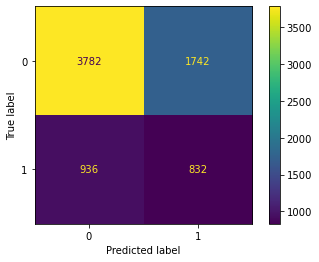

In [141]:
plot_confusion_matrix(knn_model, X_test, y_test)

In [142]:
knn_model.get_params()

{'memory': None,
 'steps': [('transformer',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('ordinal_edu',
                                    Pipeline(steps=[('ordinal',
                                                     OrdinalEncoder(cols=['name_education_type'],
                                                                    mapping=[{'col': 'name_education_type',
                                                                              'mapping': {None: 0,
                                                                                          'Academic degree': 5,
                                                                                          'Higher education': 4,
                                                                                          'Incomplete higher': 3,
                                                                                          'Lower secondary': 1,
                                       

## KNN Tuned

In [143]:
hyperparam_knn = {
    'clf__leaf_size': [10, 20, 30],
    'clf__n_neighbors': [1, 3, 5, 10],
    'clf__p': [1, 2]
}

grid_search_knn = GridSearchCV(knn_model, hyperparam_knn, scoring = 'recall', cv = 5, n_jobs = -1)
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ordinal_edu',
                                                                         Pipeline(steps=[('ordinal',
                                                                                          OrdinalEncoder(cols=['name_education_type'],
                                                                                                         mapping=[{'col': 'name_education_type',
                                                                                                                   'mapping': {None: 0,
                                                                                                                               'Academic degree': 5,
                                                                                         

In [144]:
grid_search_knn.best_params_

{'clf__leaf_size': 30, 'clf__n_neighbors': 5, 'clf__p': 2}

In [145]:
grid_search_knn.best_estimator_

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_edu',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(cols=['name_education_type'],
                                                                                  mapping=[{'col': 'name_education_type',
                                                                                            'mapping': {None: 0,
                                                                                                        'Academic degree': 5,
                                                                                                        'Higher education': 4,
                                                                                                        'Incomplete higher': 3,
                                     

In [146]:
knn_tuned = grid_search_knn.best_estimator_.fit(X_train, y_train)
y_pred_knn_tuned = knn_tuned.predict(X_test)

In [147]:
print('KNN Model Score: \n')
print(classification_report(y_test, y_pred_knn))

print('=====================================================')

print('KNN Tuned Model Score: \n')
print(classification_report(y_test, y_pred_knn_tuned))

KNN Model Score: 

              precision    recall  f1-score   support

           0       0.80      0.68      0.74      5524
           1       0.32      0.47      0.38      1768

    accuracy                           0.63      7292
   macro avg       0.56      0.58      0.56      7292
weighted avg       0.69      0.63      0.65      7292

KNN Tuned Model Score: 

              precision    recall  f1-score   support

           0       0.80      0.65      0.72      5524
           1       0.30      0.48      0.37      1768

    accuracy                           0.61      7292
   macro avg       0.55      0.56      0.54      7292
weighted avg       0.68      0.61      0.63      7292



## Voting Classifier

In [148]:
from sklearn.ensemble import VotingClassifier

In [149]:
lr = logit_model
dt = dtc_model
knn = knn_model

In [150]:
for clfs, clf_name in zip([lr, dt, knn], ['LogisticRegression', 'DecisionTree', 'KNN']):
    clfs.fit(X_train, y_train)
    y_pred = clfs.predict(X_test)
    print(f'{clf_name}: \n {classification_report(y_test, y_pred)}')

LogisticRegression: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      5524
           1       0.24      1.00      0.39      1768

    accuracy                           0.24      7292
   macro avg       0.12      0.50      0.20      7292
weighted avg       0.06      0.24      0.09      7292

DecisionTree: 
               precision    recall  f1-score   support

           0       0.79      0.73      0.76      5524
           1       0.32      0.40      0.36      1768

    accuracy                           0.65      7292
   macro avg       0.56      0.57      0.56      7292
weighted avg       0.68      0.65      0.66      7292

KNN: 
               precision    recall  f1-score   support

           0       0.80      0.67      0.73      5524
           1       0.32      0.47      0.38      1768

    accuracy                           0.63      7292
   macro avg       0.56      0.57      0.56      7292
weighted avg       0.68      

In [151]:
vc = VotingClassifier([('clf1', lr), ('clf2', dt), ('clf3', knn)], voting='soft')

In [152]:
vc.fit(X_train, y_train)

VotingClassifier(estimators=[('clf1',
                              Pipeline(steps=[('transformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('ordinal_edu',
                                                                                Pipeline(steps=[('ordinal',
                                                                                                 OrdinalEncoder(cols=['name_education_type'],
                                                                                                                mapping=[{'col': 'name_education_type',
                                                                                                                          'mapping': {None: 0,
                                                                                                                                      'Academic degree': 5,
              

In [153]:
y_pred_vc = vc.predict(X_test)

In [154]:
print(classification_report(y_test, y_pred_vc))

              precision    recall  f1-score   support

           0       0.80      0.70      0.75      5524
           1       0.33      0.46      0.38      1768

    accuracy                           0.64      7292
   macro avg       0.56      0.58      0.56      7292
weighted avg       0.68      0.64      0.66      7292



## Bagging Classifier

In [155]:
from sklearn.ensemble import BaggingClassifier

In [156]:
logit = LogisticRegression()

In [157]:
bag_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_edu',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(cols=['name_education_type'],
                                                                                  mapping=[{'col': 'name_education_type',
                                                                                            'mapping': {None: 0,
                                                                                                        'Academic degree': 5,
                                                                                                        'Higher education': 4,
                                                                                                        'Incomplete higher': 3,
                                     

In [158]:
print(classification_report(y_test,bag_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.77      0.37      0.50      5524
           1       0.25      0.65      0.36      1768

    accuracy                           0.44      7292
   macro avg       0.51      0.51      0.43      7292
weighted avg       0.64      0.44      0.47      7292



## ABC Model

In [159]:
abc_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_edu',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(cols=['name_education_type'],
                                                                                  mapping=[{'col': 'name_education_type',
                                                                                            'mapping': {None: 0,
                                                                                                        'Academic degree': 5,
                                                                                                        'Higher education': 4,
                                                                                                        'Incomplete higher': 3,
                                     

In [160]:
y_pred_abc = abc_model.predict(X_test)
print(classification_report(y_test, y_pred_abc))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      5524
           1       0.76      0.02      0.04      1768

    accuracy                           0.76      7292
   macro avg       0.76      0.51      0.45      7292
weighted avg       0.76      0.76      0.66      7292



## Gradient Boosting Classifier

In [161]:
gbc_model.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_edu',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(cols=['name_education_type'],
                                                                                  mapping=[{'col': 'name_education_type',
                                                                                            'mapping': {None: 0,
                                                                                                        'Academic degree': 5,
                                                                                                        'Higher education': 4,
                                                                                                        'Incomplete higher': 3,
                                     

In [162]:
y_pred_gbc = gbc_model.predict(X_test)
print(classification_report(y_test, y_pred_gbc))

              precision    recall  f1-score   support

           0       0.76      0.92      0.84      5524
           1       0.30      0.10      0.16      1768

    accuracy                           0.72      7292
   macro avg       0.53      0.51      0.50      7292
weighted avg       0.65      0.72      0.67      7292



In [163]:
import joblib

In [164]:
# joblib.dump(vc, 'vc')

In [165]:
# vc

In [166]:
vc = joblib.load('vc')
vc

VotingClassifier(estimators=[('clf1',
                              Pipeline(steps=[('transformer',
                                               ColumnTransformer(remainder='passthrough',
                                                                 transformers=[('ordinal_edu',
                                                                                Pipeline(steps=[('ordinal',
                                                                                                 OrdinalEncoder(cols=['name_education_type'],
                                                                                                                mapping=[{'col': 'name_education_type',
                                                                                                                          'mapping': {None: 0,
                                                                                                                                      'Academic degree': 5,
              

In [167]:
X_train.columns

Index(['code_gender', 'flag_own_car', 'flag_own_realty', 'amt_income_total',
       'name_income_type', 'name_education_type', 'name_family_status',
       'name_housing_type', 'employed', 'family_size', 'age_cat', 'cnt_child'],
      dtype='object')

In [168]:
display(app.name_education_type.value_counts())
display(app.name_income_type.value_counts())

Secondary / secondary special    24777
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Academic degree                     32
Name: name_education_type, dtype: int64

Working                 18819
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Name: name_income_type, dtype: int64

In [169]:
X_train.head(3)

,code_gender,flag_own_car,flag_own_realty,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,employed,family_size,age_cat,cnt_child
734143,M,N,Y,157500.0,Working,Secondary / secondary special,Single / not married,House / apartment,1,0,1,0
369602,M,Y,Y,157500.0,Working,Higher education,Married,House / apartment,1,0,1,0
671407,M,N,Y,135000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,1,0,1,0


In [170]:
# rose = [[1, 'female', 17, 1, 1, 90, 'S', 'Miss']]
# dtc.predict(pd.DataFrame(rose, columns=X_train.columns))

In [171]:
Ivan = [['M', 'Y', 'Y', 100, 'Working', 'Academic degree', 'Single / not married', 'House / apartment', 1, 0, 1, 0]]
Alya = [['F', 'Y', 'Y', 100000, 'Working', 'Academic degree', 'Single / not married', 'House / apartment', 0, 5, 2, 0]]

In [172]:
vc.predict(pd.DataFrame(Alya, columns=X_train.columns))

array([1])

In [173]:
vc.predict(pd.DataFrame(Ivan, columns=X_train.columns))

array([1])

In [182]:
# X_train.head(4)
app['name_housing_type'].value_counts()

House / apartment      32548
With parents            1776
Municipal apartment     1128
Rented apartment         575
Office apartment         262
Co-op apartment          168
Name: name_housing_type, dtype: int64

In [175]:
X_train.columns

Index(['code_gender', 'flag_own_car', 'flag_own_realty', 'amt_income_total',
       'name_income_type', 'name_education_type', 'name_family_status',
       'name_housing_type', 'employed', 'family_size', 'age_cat', 'cnt_child'],
      dtype='object')

In [183]:
# front-end
print('===========INPUT CUSTOMER INFORMATION===========')
code_gender = str(input('Gender (M/F): ')).upper()
flag_own_car = str(input('Have a Car? (Y/N): ')).upper()
flag_own_realty = str(input('Have a Realty? (Y/N): ')).upper()
amt_income_total = (input('Amount Income: '))
name_income_type = str(input('Income Type (Working, Commercial associate, Pensioner, State servant, Student): '))
name_education_type = str(input('Education Type (Secondary / secondary special, Higher education, Incomplete higher, Lower secondaryt, Academic degree): '))
name_family_status = str(input('Family Status: (Married, Single / not married, Civil marriage, Separated,  Widow): '))
name_housing_type = str(input('Housing Type (House / apartment, With parents, Municipal apartment, Rented apartment, Office apartment, Co-op apartment): '))
employed = (input('Working status (1.Employed 2.Unemployed) (1/2): '))
family_size = (input('Family Members (1/2/3/4...): '))
age_cat = (input('Teen/Adults/Senior (0/1/2): '))
cnt_child = (input('Number of Children (0/1/2/3/...): '))

#back-end
df = pd.DataFrame([[code_gender, flag_own_car, flag_own_realty, amt_income_total, name_income_type, 
                    name_education_type, name_family_status, name_housing_type, employed, family_size,
                   age_cat, cnt_child]], columns=X.columns, index=[0])
class_label = vc.predict(df)[0]
proba = vc.predict_proba(df)

if class_label == 0:
    print('No loan for this user')
else:
    print('Overdue! Customer must pay the bill first')
    
# print(proba)

===========INPUT CUSTOMER INFORMATION===========
Gender (M/F): M
Have a Car? (Y/N): y
Have a Realty? (Y/N): n
Amount Income: 50000
Income Type (Working, Commercial associate,Pensioner, State servant, Student): Working
Education Type (Secondary / secondary special, Higher education, Incomplete higher, Lower secondaryt, Academic degree): Academic degree
Family Status: (Married, Single / not married, Civil marriage, Separated,  Widow): Single / not married
Housing Type (House / apartment, With parents, Municipal apartment, Rented apartment, Office apartment, Co-op apartment): House / apartment
Working status (1.Employed 
2.Unemployed) (1/2): 1
Family Members (1/2/3/4...): 1
Teen/Adults/Senior (0/1/2): 1
Number of Children (0/1/2/3/...): 0
No loan for this user
[[0.63324277 0.36675723]]
